In [1]:
import pandas as pd
import numpy as np
import re

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import nltk 
#nltk.download('words')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
def remove_unnecessary_spaces_characters(sentence):
    sentence = sentence.replace("\\n\\n"," ")
    sentence = sentence.replace("b'\''"," ")
    sentence = re.sub(' +',' ',sentence)
    sentence = re.sub(r'\W+',' ',sentence)
    return sentence

def remove_stop_words(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words_list]
    return filtered_sentence

def remove_non_vocab_words(sentence):
    #sentence = nltk.wordpunct_tokenize(sentence)
    res = [x for x in sentence if x in vocab_words]
    return res

def lemmatize_words(sentence):
    res = [lemmatizer.lemmatize(x,'v') for x in sentence]
    return res

def remove_single_letters(sentence):
    
    sentence = [x for x in sentence if len(x)>2]
    return sentence

def join_words_back(word_list):
    
    try:
        return ' '.join(word for word in word_list)
    except:
        return ' '

In [3]:
file_path = "D:\\Data\\NLP\\news_headlines\\"

df =  pd.read_csv(file_path+"bbc_news.csv")
df.head()

,news,type
0,b'US consumer confidence up\n\nConsumers\' con...,business
1,b'The \'ticking budget\' facing the US\n\nThe ...,business
2,"b""Mitsubishi in Peugeot link talks\n\nTrouble-...",business
3,b'BMW reveals new models pipeline\n\nBMW is pr...,business
4,b'World leaders gather to face uncertainty\n\n...,business


In [4]:
vocab_words = set(nltk.corpus.words.words())
stop_words_list = stopwords.words('english')
text_column_name = 'news'
processed_text_column_name = 'processed_news'

In [5]:
df[processed_text_column_name] = df[text_column_name].apply(lambda x : x.lower())
df[processed_text_column_name] = df[processed_text_column_name].apply(remove_unnecessary_spaces_characters)
df[processed_text_column_name] = df[processed_text_column_name].apply(remove_stop_words)
df[processed_text_column_name] = df[processed_text_column_name].apply(remove_non_vocab_words)
df[processed_text_column_name] = df[processed_text_column_name].apply(lemmatize_words)
df[processed_text_column_name] = df[processed_text_column_name].apply(remove_single_letters)
df[processed_text_column_name] = df[processed_text_column_name].apply(join_words_back)

In [6]:
X = df[processed_text_column_name]
Y = df['type'].values
x_train,x_test,y_train,y_test = train_test_split(X,Y,stratify=Y,test_size=0.3)

In [7]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=100)

In [8]:
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [9]:
n_estimators = np.arange(5,300,50)
max_features = ['auto', 'sqrt',None]
max_depth = np.arange(10,30)
min_samples_split = np.arange(2,10,2)
min_samples_leaf = np.arange(1,10,2)
bootstrap = [True, False]

random_forest_parameters = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

In [10]:
clf = RandomForestClassifier(random_state=42)
clf_hyp = RandomizedSearchCV(estimator = clf,param_distributions = random_forest_parameters,\
                             random_state=42,scoring='f1_macro')

clf_hyp.fit(x_train,y_train)  

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]),
                                        'max_features': ['auto', 'sqrt', None],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([  5,  55, 105, 155, 205, 255])},
                   random_state=42, scoring='f1_macro')

In [11]:
clf = RandomForestClassifier(random_state=42,**clf_hyp.best_params_)
clf.fit(x_train,y_train)  
y_pred = clf.predict(x_test)

In [12]:
print(classification_report(y_test,y_pred))

               precision    recall  f1-score   support

     business       0.89      0.92      0.91       153
entertainment       0.96      0.78      0.86       116
     politics       0.93      0.92      0.92       125
        sport       0.88      0.95      0.91       154
         tech       0.89      0.92      0.90       120

     accuracy                           0.90       668
    macro avg       0.91      0.90      0.90       668
 weighted avg       0.91      0.90      0.90       668



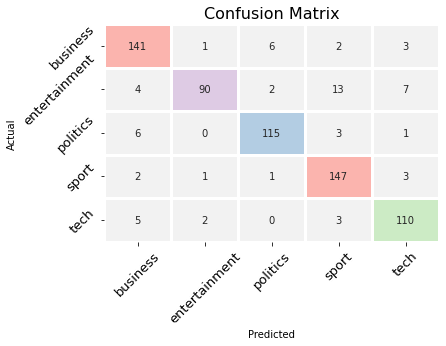

In [13]:
sns.heatmap(pd.crosstab(y_test,y_pred),annot=True, cmap="Pastel1_r" ,\
            fmt='d',linecolor='white',\
            cbar=False,linewidths=3)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45,fontsize=13)
plt.yticks(rotation=45,fontsize=13)
plt.title("Confusion Matrix",fontsize=16);